In [1]:
import numpy as np

from IPython.html.widgets import *
from IPython.display import display

import matplotlib.pylab as plt
%matplotlib inline
import seaborn
seaborn.set()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from scipy.spatial.distance import pdist, cdist, euclidean, squareform

# Kernel Regression

In [3]:
def gaussian_kernel_regresson(x, y, x_test, sigma):
    D = cdist(x_test.reshape((-1,1)), x.reshape((-1,1)), euclidean)
    K = np.exp(-D**2/2/sigma**2)
    W = K/K.sum(axis=1)[:, np.newaxis]
    mean_test = W.dot(y)
    var_test = W.dot(y**2)-mean_test**2+sigma**2
    std_test = np.sqrt(var_test)
    return mean_test, std_test

In [95]:
def kernel_regression_demo(sigma0=0,sigma=0.1, seed=0, size=5):
    rng = np.random.RandomState(seed)
    x = rng.rand(size)
    f = lambda x: np.sin(x*2*np.pi)
    x_test = np.linspace(0,1,101)
    y_ = f(x)
    y = y_ + rng.randn(x.size)*sigma0

    plt.figure(figsize=(10,8))
    plt.plot(x_test,f(x_test), label='true')
    plt.plot(x,y,'o', label='data')
    pred_test, std_test = gaussian_kernel_regresson(x, y, x_test, sigma)
    
    plt.plot(x_test, pred_test, 'r')
    plt.fill_between(x_test, pred_test-2*std_test, pred_test+2*std_test, facecolor='red', alpha=0.2, label='prediction')
    plt.legend()
    
    return x_test, pred_test, std_test

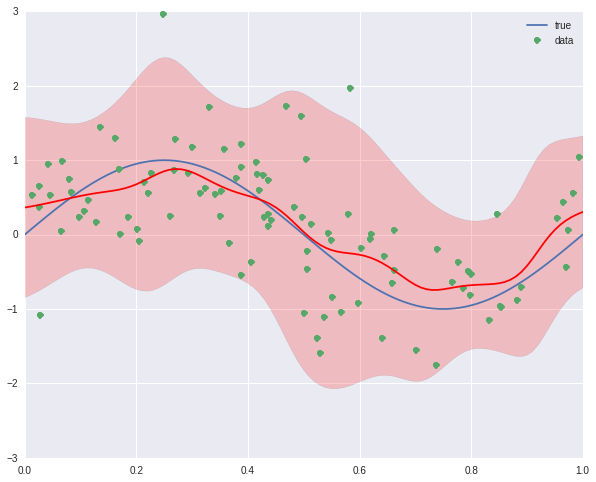

In [97]:
w = interactive(kernel_regression_demo, 
                sigma0 = FloatText(value=0.01),
                sigma=FloatText(value=0.05),
                seed=IntText(0), size=IntText(30))
display(w)

# Gaussian Process

## gaussian vs absolute kernel

In [9]:
def gaussian_kernel(X,sigma):
    return np.exp(-1/2/(sigma**2)*squareform(pdist(X, euclidean))**2)

In [10]:
def exponential_kernel(X,sigma):
    return np.exp(-1/sigma*squareform(pdist(X, euclidean)))

In [120]:
def gp_sampling(seed=0, sigma=0.1, alpha=1, nsample=5):
    X = np.linspace(-1,1,101).reshape((-1,1))
    
    rng = np.random.RandomState(seed)
    K1 = gaussian_kernel(X, sigma)/alpha
    samples1 = rng.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K1, size=nsample)
    K2 = exponential_kernel(X, sigma)/alpha
    samples2 = rng.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K2, size=nsample)
    
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    for x in samples1:
        plt.plot(x)
    plt.title('gaussian')
    plt.subplot(1,2,2)
    for x in samples2:
        plt.plot(x)
    plt.title('absolute')
    plt.show()
    
    print(np.linalg.cond(K1))
    print(np.linalg.cond(K2))
    return K1, K2

$$ K_1(x,x') = \frac{1}{\alpha} e^{-\frac{1}{2 \sigma^2} ||x-x'||^2} $$
$$ K_2(x,x') = \frac{1}{\alpha} e^{-\frac{1}{\sigma} ||x-x'||} $$

/usr/local/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.


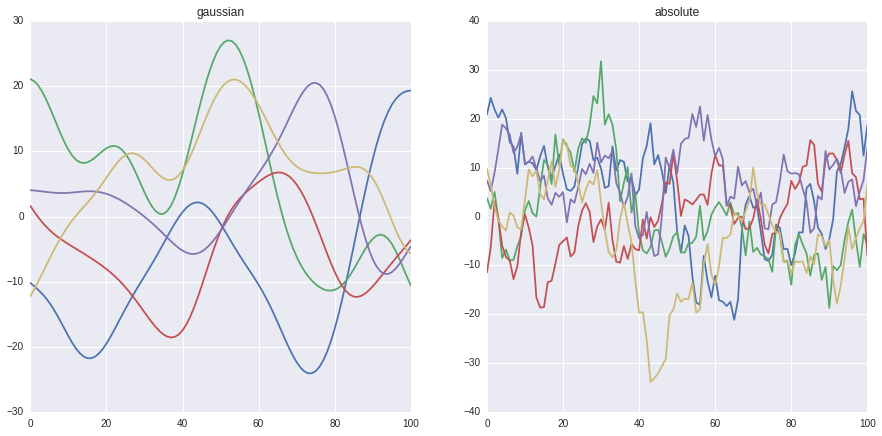

8.70343486417e+18
375.129422985


In [124]:
w = interactive(gp_sampling, seed=IntText(value=0), sigma=FloatText(value=0.1),
                alpha=FloatText(value=1), nsample=IntText(value=5))
display(w)

## fitting

In [19]:
from sklearn.gaussian_process import GaussianProcess

In [122]:
def gp_demo(sigma0=0,sigma=0.1, optimize_sigma =False, size=5, seed=0, random_state=43):
    rng = np.random.RandomState(seed)
    x = rng.rand(size)
    f = lambda x: np.sin(x*2*np.pi)
    x_test = np.linspace(0,1,101)
    y_ = f(x)
    y = y_ + rng.randn(x.size)*sigma0
    
    sigma_min = 1e-3
    sigma_max = 1e3
    
    gp1_param = {'random_state': random_state,
                'normalize':False,
                'theta0':1/2/sigma**2,
                }
    
    gp2_param = {'random_state': random_state,
                 'normalize':False,
                 'theta0':1/sigma,
                 'corr':'absolute_exponential',
                }
    
    
    if optimize_sigma:
        gp1_param.update({
                'thetaL': 1/2/sigma_max**2,
                'thetaU': 1/2/sigma_min**2,
            })
        gp2_param.update({
                'thetaL': 1/sigma_max,
                'thetaU': 1/sigma_min,
            })
    
    gp1 = GaussianProcess(**gp1_param)
    gp2 = GaussianProcess(**gp2_param)
    gp1.fit(x[:, np.newaxis], y)
    gp2.fit(x[:, np.newaxis], y)
    print('gaussian: theta = {}'.format(np.sqrt(1/2/gp1.theta_)))
    print('absolute: theta = {}'.format(1/gp2.theta_))
    pred_test1, mse_test1 = gp1.predict(x_test[:, np.newaxis], eval_MSE=True)
    std_test1 = np.sqrt(mse_test1)
    pred_test2, mse_test2 = gp2.predict(x_test[:, np.newaxis], eval_MSE=True)
    std_test2 = np.sqrt(mse_test2)


    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    
    plt.plot(x_test,f(x_test), label='true')
    plt.plot(x,y,'o', label='data')    
    plt.plot(x_test, pred_test1, 'r')
    plt.fill_between(x_test, pred_test1-2*std_test1, pred_test1+2*std_test1, facecolor='red', alpha=0.2, label='prediction')
    plt.legend()
    plt.title('gaussian')
    
    plt.subplot(1,2,2)
    
    plt.plot(x_test,f(x_test), label='true')
    plt.plot(x,y,'o', label='data')    
    plt.plot(x_test, pred_test2, 'r')
    plt.fill_between(x_test, pred_test2-2*std_test2, pred_test2+2*std_test2, facecolor='red', alpha=0.2, label='prediction')
    plt.legend()
    plt.title('absolute')
    
    return gp1, gp2

gaussian: theta = [[ 10.]]
absolute: theta = [[ 10.]]


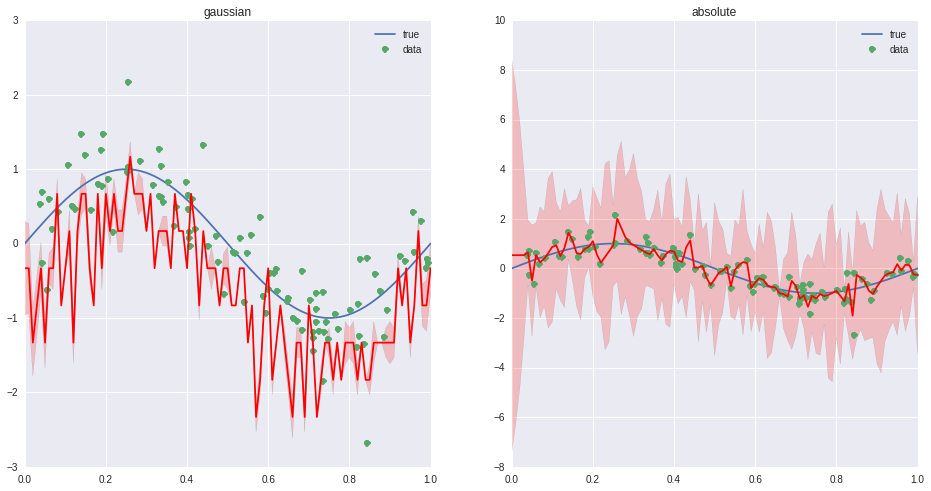

In [123]:
w = interactive(gp_demo, 
                sigma0 = FloatText(value=0.01),
                sigma=FloatText(value=0.05),
                size=IntText(30),
                seed=IntText(0),
                random_state = IntText(42),
                optimize_sigma = True
               )
display(w)